## Data Correlation
For each columns used in the paper we calculate Spearman correlation for each posible pair 

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
%cd ..

/home/belu/VS Workplace/2021-re-pendleton-perovskite


In [2]:
import src.data.notebook_utils as utils

results = 'notebooks/results/correlation/'

df = utils.read_data()

columns_by_type = utils.get_columns(df.columns)
used_data = utils.get_used_columns(df.columns)
selected_columns = set()

FileNotFoundError: [Errno 2] No such file or directory: 'data/raw/types.json'

In [21]:
selected_columns = selected_columns.union(columns_by_type['_feat_'],columns_by_type['solUD'],columns_by_type['chem'])

In [22]:
len(selected_columns)

111

In [23]:
for key, cols in columns_by_type.items():
    print('#Cols for type {}: {}'.format(key, len(cols)))

#Cols for type _rxn_: 9
#Cols for type _feat_: 67
#Cols for type _raw: 797
#Cols for type solUD: 8
#Cols for type solV: 8
#Cols for type chem: 36


In [24]:
columns_by_type.keys()

dict_keys(['_rxn_', '_feat_', '_raw', 'solUD', 'solV', 'chem'])

In [25]:
final_df = df[selected_columns]

In [26]:
len(final_df)

4993

All columns are numeric

A bit more about raw_reagent information to be considered:

For each reagent precursor (not all of them), there are +/-:
-   Concentration of each compounds used: by inchikey NOT USED FOR STD. Ex _raw_reagent_2_conc_QNNYEDWTOZODAS-UHFFFAOYSA-N'
-   instructions (duration, volume, volumen units, etc) Ex _raw_reagent_2_instructions_0_duration_units'
-   Concentration for SolUD ("_v1-") Ex'_raw_reagent_2_v1-conc_BAMDIFIROXTEEM-UHFFFAOYSA-N
-   Volume in total Ex _raw_reagent_2_volume
-   Amount of each chemical c Ex_raw_reagent_3_chemicals_0_actual_amount 

'_raw_smiles','_raw_smiles_standard',
 '_raw_standard_molweight',
 '_raw_standardized_smiles',
 '_raw_temperatureC_nominal',
 '_raw_timecompleted_UTC',
 '_raw_timecreated_UTC',
 '_raw_v0-M_acid',
 '_raw_v0-M_inorganic',
 '_raw_v0-M_organic',

 +
 _raw_v1-mmol
 _raw_v1-M

### Pearson Correlaation
First we should check if our data has a Normal distribution.

In [13]:
import scipy.stats as stats
import numpy as np 

In [10]:
normal_cols = 0
column_normalization = dict()
for column in selected_columns:
    value = round(stats.normaltest(df[column])[1], 4)
    if (value >= 0.05):
        print(column)
        normal_cols+=1

_feat_LengthPerpendicularToTheMaxArea
_feat_maximalprojectionsize


From only two columns there are enough evidence to affirm that its data don't belong to a non-normal distribution.

### Spearman Correlation
Decied to move on with this kind of correlation because it does not assume any specific distribution

In [13]:
import itertools as it 
import numpy as np

combinations = np.array(list(it.combinations(selected_columns, 2)))

In [16]:
spearman_corr = final_df.corr('spearman')

In [17]:
spearman_correlation = np.zeros(combinations.shape[0])
for i, pair in enumerate(combinations):
    spearman_correlation[i] = spearman_corr[pair[0]][pair[1]]

In [18]:
sort_index = np.argsort(spearman_correlation)
spearman_correlation = spearman_correlation[sort_index]
combinations = combinations[sort_index]

In [19]:
correlations = pd.DataFrame(combinations)
correlations['correlation'] = spearman_correlation
correlations.sort_values(['correlation'],ascending=False)
correlations.dropna(inplace=True)
correlations.rename({0:'column1', 1:'column2'}, inplace=True, axis=1)

In [20]:
correlations.sort_values(['correlation'],ascending=False).to_csv(results+'feat_correlations_spearman.csv', index=None)


In [21]:
correlations_plot = correlations.sort_values(['correlation'],ascending=False)


In [22]:
len(correlations_plot)

3486

### Spearman Correlation - by Plotly

In [14]:
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.offline as pyo

from scipy.spatial.distance import pdist, squareform

import scipy.cluster.hierarchy as sch

pyo.init_notebook_mode(connected=True)

def corr_heatmap(numpy_array, columns, title, dendogramMethod='median'):
    data_array = numpy_array
    labels = columns
    colorScale = 'default'
   
    # Initialize figure by creating upper dendrogram
    #fig = ff.create_dendrogram(data_array, orientation='bottom', linkagefun=lambda x: sch.linkage(x, method=dendogramMethod, metric=distanceMethod ,optimal_ordering=True), labels=labels)
    fig = ff.create_dendrogram(data_array, orientation='bottom', linkagefun=lambda x: sch.linkage(x, method=dendogramMethod, optimal_ordering=True), labels=labels)
    for i in range(len(fig['data'])):
        fig['data'][i]['yaxis'] = 'y2'

    # Create Side Dendrogram
    #dendro_side = ff.create_dendrogram(data_array, orientation='right', linkagefun=lambda x: sch.linkage(x, method=dendogramMethod, metric=distanceMethod,  optimal_ordering=True) )
    dendro_side = ff.create_dendrogram(data_array, orientation='right', linkagefun=lambda x: sch.linkage(x, method=dendogramMethod, optimal_ordering=True) )

    for i in range(len(dendro_side['data'])):
        dendro_side['data'][i]['xaxis'] = 'x2'

    # Add Side Dendrogram Data to Figure
    # ~ stack1 = []
    for data in dendro_side['data']:
        fig.add_trace(data)


    # Create Heatmap
    dendro_leaves = dendro_side['layout']['yaxis']['ticktext']
    dendro_leaves = list(map(int, dendro_leaves))
    heat_data = data_array
    heat_data = heat_data[dendro_leaves,:]
    heat_data = heat_data[:,dendro_leaves]

    if(colorScale!='default'):
        aux=go.Heatmap(
            x = dendro_leaves,
            y = dendro_leaves,
            z = heat_data,
            colorscale = colorScale,
            colorbar=dict(title='Trie distances'),
            )
        heatmap = [aux]
    else:
        aux = go.Heatmap(
            x=dendro_leaves,
            y=dendro_leaves,
            z=heat_data,
            colorbar=dict(title='Correlación (abs)'),
        )
        heatmap = [aux]
        # heatmap = [
        # 	go.Heatmap(
        # 		x = dendro_leaves,
        # 		y = dendro_leaves,
        # 		z = heat_data
        # 	)
        # ]
	
    heatmap[0]['x'] = fig['layout']['xaxis']['tickvals']
    heatmap[0]['y'] = dendro_side['layout']['yaxis']['tickvals']
    # Add Heatmap Data to Figure
    for data in heatmap:
        fig.add_trace(data)


    # Edit Layout
    fig.update_layout({'width':800, 'height':800,
                            'showlegend':False, 'hovermode': 'closest',
                            })

    fig.update_layout(title={
                        'text': title,
                        'y':0.9,
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'})

    # Edit xaxis
    fig.update_layout(xaxis={'domain': [.15, 1],
                                    'mirror': False,
                                    'showgrid': False,
                                    'showline': False,
                                    'zeroline': False,
                                    'ticks':""})
    # Edit xaxis2
    fig.update_layout(xaxis2={'domain': [0, .15],
                                    'mirror': False,
                                    'showgrid': False,
                                    'showline': False,
                                    'zeroline': False,
                                    'showticklabels': False,
                                    'ticks':""})

    # Edit yaxis
    fig.update_layout(yaxis={'domain': [0, .85],
                                    'mirror': False,
                                    'showgrid': False,
                                    'showline': False,
                                    'zeroline': False,
                                    'showticklabels': False,
                                    'ticks': ""
                            })
    # Edit yaxis2
    fig.update_layout(yaxis2={'domain':[.825, .975],
                                        'mirror': False,
                                        'showgrid': False,
                                        'showline': False,
                                        'zeroline': False,
                                        'showticklabels': False,
                                        'ticks':""})
    # ~ print(fig)
    fig['layout']['yaxis']['ticktext'] = fig['layout']['xaxis']['ticktext']
    fig['layout']['yaxis']['tickvals'] = fig['layout']['xaxis']['tickvals']


    #fig.show()

    pyo.iplot(fig, filename='test')

In [27]:
feat_col = list(columns_by_type['_feat_'])
solud_col = list(columns_by_type['solUD'])
chem_col = list(columns_by_type['chem'])
feat_solud = feat_col + solud_col
chem_solud = chem_col + solud_col


In [28]:
def plot_corr_dendogram(df, columns, title, method):
    df_feat = df[columns]
    df_feat_noctes = df_feat.loc[:, (df_feat != df_feat.iloc[0]).any()] 
    df_feat_cols = df_feat_noctes.columns
    corr_df = df_feat_noctes.corr(method='spearman').values
    corr_df = np.absolute(corr_df)
    corr_heatmap(corr_df, df_feat_cols,title, method)
     

In [29]:
count = [len(final_df[col].unique()) for col in final_df[feat_col]]

In [ ]:
df_weight_per_feature = pd.to_csv('fetures_sorted_by_weight.csv', index=None)

In [58]:
count.sort()

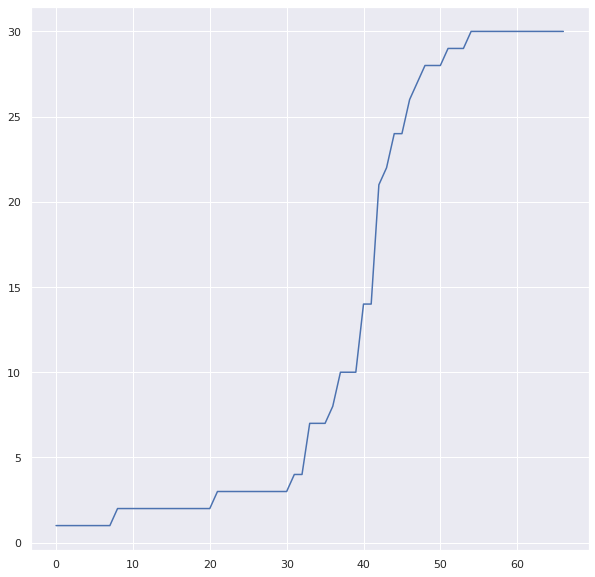

In [59]:
plt.plot(np.arange(len(feat_col)), count, ylabel='Cantidad de filas')

In [63]:
discrete_col = [ col for col in feat_col if len(final_df[col].unique()) < 5]
# mirar entre 10 a 15
# analizar los pesos de gbc
# y vs pesos de las columnas en GBC

In [64]:
discrete_col

['_feat_RingAtomCount',
 '_feat_CarboRingCount',
 '_feat_AtomCount_N',
 '_feat_fr_guanido',
 '_feat_Hacceptorcount',
 '_feat_fr_amidine',
 '_feat_HeteroaromaticRing Count',
 '_feat_AromaticRingCount',
 '_feat_fr_NH1',
 '_feat_fr_Imine',
 '_feat_fr_dihydropyridine',
 '_feat_donsitecount',
 '_feat_fr_quatN',
 '_feat_fr_piperzine',
 '_feat_fr_piperdine',
 '_feat_ChiralCenterCount',
 '_feat_CarboaromaticRingCount',
 '_feat_donorcount',
 '_feat_SmallestRingSize',
 '_feat_Hdonorcount',
 '_feat_LargestRingSize',
 '_feat_CyclomaticNumber',
 '_feat_acceptorcount',
 '_feat_CarboaliphaticRingCount',
 '_feat_fr_NH0',
 '_feat_AliphaticRingCount',
 '_feat_AromaticAtomCount',
 '_feat_fr_pyridine',
 '_feat_fr_Ar_NH',
 '_feat_HeteroaliphaticRingCount',
 '_feat_fr_NH2',
 '_feat_Accsitecount',
 '_feat_fr_ArN']

In [65]:
feat_cont_cols = [col for col in feat_col if col not in discrete_col]

In [66]:
#COLUMNAS DE VALORES DISCRETOS
plot_corr_dendogram(final_df, discrete_col, 'Propiedades físico-químicas <10 valores distintos', 'average')


In [67]:
#COLUMNAS CON MÁS DE 10 VALORES DISTINTOS
plot_corr_dendogram(final_df, feat_cont_cols, 'Propiedades físico-químicas: discritas (>10 valores distintos)', 'average')

In [25]:
plot_corr_dendogram(final_df, feat_col, 'Propiedades físico-químicas', 'average')


In [30]:
plot_corr_dendogram(final_df, feat_col, 'Propiedades físico-químicas', 'centroid')


In [204]:
plot_corr_dendogram(final_df, solud_col, 'Condiciones de Reacción')


In [195]:
plot_corr_dendogram(final_df, chem_col, 'Info usada de las soluciones precursoras')


In [196]:
plot_corr_dendogram(final_df, chem_col + solud_col +feat_col , 'FQ+reacción+sc precursoras')

In [32]:
plot_corr_dendogram(final_df,  solud_col +feat_col , 'FQ+reacción', 'centroid')

In [197]:
df_feat = final_df[feat_col]
df_feat_noctes = df_feat.loc[:, (df_feat != df_feat.iloc[0]).any()] 
df_feat_cols = df_feat_noctes.columns

In [198]:
corr_df = final_df[df_feat_cols].corr(method='spearman')

In [199]:
corr_df.head()

,_feat_BondCount,_feat_ChainAtomCount,_feat_HeteroaliphaticRingCount,_feat_VanderWaalsVolume,_feat_AliphaticRingCount,_feat_Refractivity,_feat_RotatableBondCount,_feat_CarboaliphaticRingCount,_feat_VanderWaalsSurfaceArea,_feat_MinimalProjectionRadius,...,_feat_fr_NH2,_feat_ProtPolarSurfaceArea,_feat_AromaticAtomCount,_feat_CarboRingCount,_feat_Aliphatic AtomCount,_feat_RingAtomCount,_feat_Accsitecount,_feat_MinimalProjectionArea,_feat_maximalprojectionsize,_feat_ASA
_feat_BondCount,1.000000,0.508423,-0.112287,0.967799,0.019113,0.838476,0.876134,0.190136,0.967321,0.771108,...,-0.391613,-0.376390,0.451027,0.496221,0.561861,0.442099,-0.404723,0.957057,0.749992,0.944157
_feat_ChainAtomCount,0.508423,1.000000,-0.308383,0.508491,-0.361842,0.476914,0.607975,-0.184160,0.493292,0.440229,...,0.122445,0.129436,-0.152347,-0.205813,0.810120,-0.305200,-0.023624,0.396603,0.514649,0.457829
_feat_HeteroaliphaticRingCount,-0.112287,-0.308383,1.000000,-0.060820,0.809992,0.023639,-0.137401,-0.022268,-0.266321,-0.049832,...,0.245186,-0.337339,-0.079851,-0.084224,0.165792,0.261662,0.244580,0.009246,-0.223153,-0.302303
_feat_VanderWaalsVolume,0.967799,0.508491,-0.060820,1.000000,0.048681,0.893195,0.827169,0.168328,0.889745,0.866900,...,-0.231485,-0.259249,0.514249,0.550343,0.576523,0.512187,-0.256904,0.897211,0.609290,0.870872
_feat_AliphaticRingCount,0.019113,-0.361842,0.809992,0.048681,1.000000,0.106350,-0.054798,0.568259,-0.122432,0.075508,...,0.161485,-0.308313,-0.098583,0.085769,0.251387,0.361098,0.156393,0.116221,-0.101706,-0.193591


In [200]:
#corr_df = corr_df.dropna(axis='columns')

In [202]:
#corr_heapmap(corr_df, df_feat_cols)